# THIS PYTHON CODE ALLOWS POPULATION ANALYSIS OF TWO-PHOTON CALCIUM IMAGING DATA. E.G., SEE PANICCIA ET AL 2024 NEURON

### IMPORT NECESSARY PACKAGES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import subprocess
import time
import pandas
import pickle
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import accuracy_score, silhouette_score, adjusted_rand_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
import scipy.stats as stats
import scipy.io as sio
from scipy import interpolate
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import matplotlib.patches as mpatches
import sys
import re
import random
np.set_printoptions(suppress=True)


### FUNCTIONS FOR SUBSEQUENT DATA EXTRACTION AND ANALYSIS

In [17]:
frameaveraging = 4
timebetweenframes = 33.33333
framerate = 1000/timebetweenframes/frameaveraging

def analyze_single_session(indir, window_size, pre_window_size):
        
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'raw_averaged' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']
    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'raw_averaged' in f and not 'part2' in f and not 'part3' in f]
        npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and not 'results' in f and not 'part2' in f and not 'part3' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numrois = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'part2' in f  and 'raw_averaged' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        signals = np.hstack((signals, signals2))
        
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)
        
        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
        
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'part3' in f and 'raw_averaged' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        signals = np.hstack((signals, signals3))
        
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        
        
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    
    ###THIS SECTION DEFINES CERTAIN INPUTS IN EVENTLOG AS BEHAVIORAL STIMULI (LEVER PRESS, CUE, ETC)
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]
    
    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T

    if animal == 'PNAC5' or animal == 'PNAC6':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1])
        
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    
    ###COMBINES ALL PRESSES
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))
    
    def calculate_aligneddata_forevent(data, frame_after_event):
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        align = np.NAN*np.zeros([numtrials,window_size,numrois])
        align_to_plot = np.NAN*np.zeros([numtrials,window_size,numrois])###CHANGED ON AUGUST 20 2021

        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            tempindex = int(tempindex)
            tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
            startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
            tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
            endindex = tempendindex.astype(int)  
            prevendindex = tempindex+endindex
            align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] \
                         = temp[tempindex-startindex:tempindex+endindex,:]
            align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] \
                         = temp[tempindex-tempstartindex:tempindex+endindex,:]

         
        align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0,0]))[0],:,:]     
            
        return align, align_to_plot, framenumberfor_eventofinterest

    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  ###CHANGE LAST VARIABLE TO CHANGE EXTRACTED INFO
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1
    
    return populationdata_activelever, populationdata_activelever, align_activelever, align_activelever, framerate


    ###NOTE:  populationdata_sucrose is CS+ responses for each neuron, averaged across trials (2 dimensional). Used for population heat maps.
    ###NOTE:  align_sucrose is the same, but not averaged across trials (3 dimensional). Use for PieCharts and individual cell responses.

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2


def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function implements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index


###Artifically inserts frames timestamps from prior datasets

behaviordata_noframes = sio.loadmat\
    (r'/Users/jmo204/Dropbox/2P Imaging Projects/Kelsey/PVT Self Admin/Codes/matfile_noframes_self ad.mat')
eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

max_of_eventlog_noframes = max(eventlog_noframes[:,1])
length_of_eventlog_noframes = len(eventlog_noframes[:,1])
x = np.vstack((eventlog_noframes, eventlog_noframes))
x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
eventlog_noframes = x

###Provides about 4.05 hours worth of frames if not frame averaging)
assumed_frame_timestamps = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO



### LOAD DATA FROM EXISTING DIRECTORIES AND PLOT AS HEATMAPS FOR EACH DAY

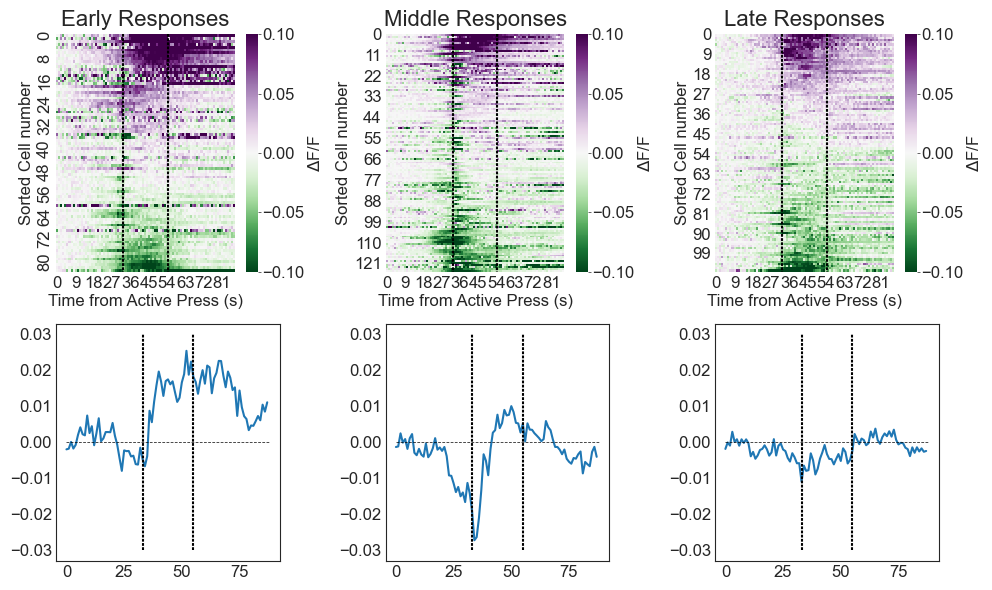

In [18]:
#### THIS SECTION IS FOR REINSTATEMENT ####
### REINSTATEMENT IF RUNNING FROM JIM'S MACBOOK PRO
basedir = r"/Users/jmo204/Dropbox/2P Imaging Projects/Kelsey/PVT Self Admin"
earlybasedir = r"/Users/jmo204/Dropbox/2P Imaging Projects/Kelsey/PVT Self Admin/YOHRein"
middlebasedir = r"/Users/jmo204/Dropbox/2P Imaging Projects/Kelsey/PVT Self Admin/DrugRein"
latebasedir = r"/Users/jmo204/Dropbox/2P Imaging Projects/Kelsey/PVT Self Admin/CueRein"

### THESE ARE CUE,DRUG,YOH REIN ANIMALS OF INTEREST 
early_animals_of_interest = ['PNAC-IG1','PNAC5','PNAC6','PNAC11'] 
middle_animals_of_interest = ['PNAC-IG1', 'PNAC5','PNAC6','PNAC8','PNAC11','PNAC12'] 
late_animals_of_interest = ['PNAC-IG1','PNAC5','PNAC6','PNAC11','PNAC12']  

### PICK THE FRAMES THAT YOU WANT TO BE PLOTTED
pre_window_size = int(4.5*framerate) #How many frames per trial before origin to be plotted?
window_size =  int((pre_window_size*2)+(3*framerate)) #How many frames do you want to plot around the origin?
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))

### FIGURE SETTINGS
fig, axs = plt.subplots(2, 3, figsize=(10, 6))
sns.set_style('white')

cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

###THIS IS FOR EARLY SESSIONS
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))

for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(earlybasedir, animal, fov),
                                                            window_size, pre_window_size)

        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        numneurons=populationdata_active_population.shape[0]
        
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_early = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size:pre_window_size*2], axis=1)
sortresponse = np.argsort(tempresponse)[::-1]

ax = axs[0,0]
sns.heatmap(pop_active[sortresponse,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
           cbar_kws={'label': '$\Delta$F/F'})
ax.grid(False)
ax.set_title('Early Responses')
ax.set_ylabel('Sorted Cell number')
ax.set_xlabel('Time from Active Press (s)')
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_early], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_early], '--k', linewidth=1.5) 

ax = axs[1,0]
ax.plot(np.mean(pop_active, axis = 0))
ax.plot([pre_window_size, pre_window_size],
         [-.03,.03],'--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [-.03,.03], '--k', linewidth=1.5) 
ax.plot([0, window_size],
        [0,0], '--k', linewidth=0.5) 

early_active = pop_active

###THIS IS FOR MIDDLE SESSIONS
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))


for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(middlebasedir, animal, fov),
                                                            window_size, pre_window_size)

        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        numneurons=populationdata_active_population.shape[0]
        
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_middle = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size:pre_window_size*2], axis=1)
sortresponse = np.argsort(tempresponse)[::-1]

ax = axs[0,1]
sns.heatmap(pop_active[sortresponse,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
           cbar_kws={'label': '$\Delta$F/F'})
ax.grid(False)
ax.set_title('Middle Responses')
ax.set_ylabel('Sorted Cell number')
ax.set_xlabel('Time from Active Press (s)')
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_middle], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_middle], '--k', linewidth=1.5) 

ax = axs[1,1]
ax.plot(np.mean(pop_active, axis = 0))
ax.plot([pre_window_size, pre_window_size],
         [-.03,.03],'--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [-.03,.03], '--k', linewidth=1.5) 
ax.plot([0, window_size],
        [0,0], '--k', linewidth=0.5) 

middle_active = pop_active

###THIS IS FOR LATE SESSIONS
populationdata_active_population = np.nan*np.ones((1, window_size)) # The second _population refers to population across all animals and FOVs
populationdata_inactive_population = np.nan*np.ones((1, window_size))

for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(latebasedir, animal, fov),
                                                            window_size, pre_window_size)

        populationdata_active_population = np.vstack((populationdata_active_population, temp1))
        populationdata_inactive_population = np.vstack((populationdata_inactive_population, temp2))

        numneurons=populationdata_active_population.shape[0]
        
populationdata_active_population = populationdata_active_population[1:,:]
populationdata_inactive_population = populationdata_inactive_population[1:,:]

baseline = np.mean(populationdata_active_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_active = populationdata_active_population - baseline[:,None]
baseline = np.mean(populationdata_inactive_population[:,baselinefirstframe:baselinelastframe], axis=1)
pop_inactive = populationdata_inactive_population - baseline[:,None]
numrois_late = pop_active.shape[0]
tempresponse = np.mean(pop_active[:,pre_window_size:pre_window_size*2], axis=1)
sortresponse = np.argsort(tempresponse)[::-1]

ax = axs[0,2]
sns.heatmap(pop_active[sortresponse,:], ax=ax, vmax = cmax, vmin = cmin, linewidth=0, cmap=plt.get_cmap('PRGn_r'),
           cbar_kws={'label': '$\Delta$F/F'})
ax.grid(False)
ax.set_title('Late Responses')
ax.set_ylabel('Sorted Cell number')
ax.set_xlabel('Time from Active Press (s)')
ax.plot([pre_window_size, pre_window_size],
        [0, numrois_late], '--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [0, numrois_late], '--k', linewidth=1.5) 

ax = axs[1,2]
ax.plot(np.mean(pop_active, axis = 0))
ax.plot([pre_window_size, pre_window_size],
         [-.03,.03],'--k', linewidth=1.5)
ax.plot([infusionframe, infusionframe],
        [-.03,.03], '--k', linewidth=1.5)
ax.plot([0, window_size],
        [0,0], '--k', linewidth=0.5) 

late_active = pop_active

fig.tight_layout()
# fig.savefig(os.path.join(basedir, 'Results', 'PNAC HEROIN REIN - Population.PDF'), format='PDF')


# CLUSTERING: ONLY USE THIS SECTION IF YOU WANT TO REDO CLUSTERING!

In [19]:
### COMBINE EARLY, MIDDLE, AND LATE DIRECTORIES FOR CLUSTERING
### ONLY RUN IF YOU WANT TO COMBINE DATA ACROSS TESTS FOR CLUSTERING

new_active = np.vstack((early_active, middle_active, late_active))


In [20]:
#PARAMETERS
sns.set_style('ticks')
import matplotlib as mpl
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.labelspacing'] = 0.2
mpl.rcParams['axes.labelpad'] = 2
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['lines.scale_dashes'] = False
mpl.rcParams['lines.dashed_pattern'] = (2, 1)
mpl.rcParams['font.sans-serif'] = ['Arial']
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'

In [21]:
#CLUSTERING FUNCTIONS

def standardize_plot_graphics(ax):
    [i.set_linewidth(0.5) for i in ax.spines.itervalues()]
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return ax

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, **kwargs):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], **kwargs)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', linecolor='r', markersize=3,
                            show_pval=True):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)   
    if show_pval:
        plot_label = '%s p=%.2e\nr=%.3f'% (plot_label, pvalue, np.sign(slope)*np.sqrt(R2))
    else:
        plot_label = '%s r=%.3f'% (plot_label, np.sign(slope)*np.sqrt(R2))
    ax.scatter(x, y, color=color, label=plot_label, s=markersize)
    ax.plot(temp, temppred, color=linecolor)
    return ax, slope, pvalue, R2

(316, 88) array for clustering


/var/folders/pk/ygvbglbn6bq1fx39y5xg76dc0000gn/T/ipykernel_10554/1714190165.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


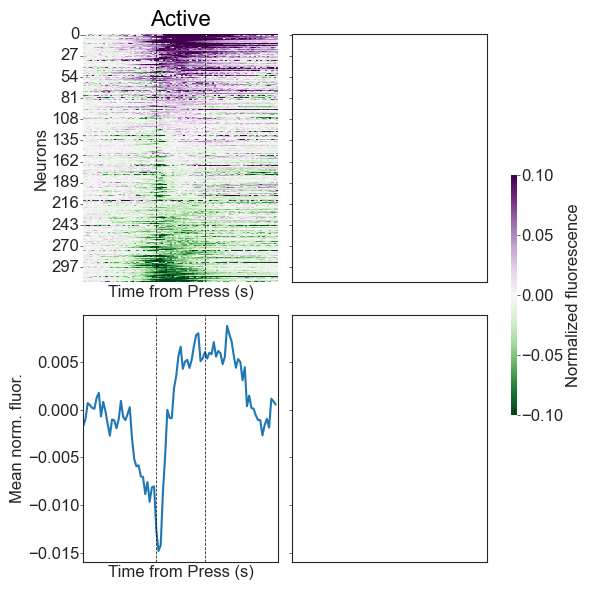

In [23]:
#Plot data that will be clustered in subsequent cells

populationdata = new_active

print (populationdata.shape, 'array for clustering')

numneurons = populationdata.shape[0]
populationdata_nan_excluded = np.nan*np.ones((1, window_size))

for i in range(numneurons):
    if np.mean(populationdata[i]) < 1000:
        populationdata_nan_excluded = np.vstack((populationdata_nan_excluded,populationdata[i]))
populationdata_nan_excluded = populationdata_nan_excluded[1:,:]
if np.shape(populationdata) != np.shape(populationdata_nan_excluded):
    print ('NaNs were deleted, the variable "populationdata" has been updated')
    print (populationdata.shape, 'array without NaN neurons')
    
    
sortwindow = [pre_window_size, infusionframe] # Sort responses between CS+ onset and reward.
sortresponse = np.argsort(np.mean(populationdata[:,sortwindow[0]:sortwindow[1]], axis=1))[::-1]

# sortresponse corresponds to an ordering of the neurons based on their average response in the sortwindow

cmax = 0.1 # Maximum colormap value. 

trial_types = ['Active']

fig, axs = plt.subplots(2,2,figsize=(3*2,3*2), sharex='all', sharey='row')
cbar_ax = fig.add_axes([0.86, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

for t in range(len(trial_types)):
    axs[0,t].set_title(trial_types[t])
    ax = axs[0,t]
    sns.heatmap(populationdata[sortresponse, t*window_size: (t+1)*window_size],
                ax=ax,
                cmap=plt.get_cmap('PRGn_r'),
                vmin=-cmax,
                vmax=cmax,
                cbar=(t==0),
                cbar_ax=cbar_ax if (t==0) else None,
                cbar_kws={'label': 'Normalized fluorescence'})
    ax.grid(False)
    ax.tick_params(width=0.5)   

    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    
        
    ax = axs[1,t]
    sns.lineplot(data=np.mean(populationdata[sortresponse, t*window_size:(t+1)*window_size], axis=0), dashes=False,
               ax=ax)
    ax.axvline(pre_window_size, linestyle='--', color='k', linewidth=0.5)    
    ax.axvline(infusionframe, linestyle='--', color='k', linewidth=0.5)    
    ax.set_xlabel('Time from Press (s)')
    ax.set_xticks([])
    
axs[0,0].set_ylabel('Neurons')
axs[1,0].set_ylabel('Mean norm. fluor.')


fig.tight_layout()
fig.subplots_adjust(right=0.82)
    

In [24]:
###IF YOU PREFER, YOU CAN CUT THE NUMBER OF FRAMES USED FOR CLUSTERING IN THIS CELL
populationdata = new_active[:,pre_window_size-(int(framerate*1)):infusionframe+int(framerate*1)]

Number of PCs = 36
[70.66315272 13.38400683  3.1006184   2.06856185  1.175481    1.06945569
  0.77364766  0.63855849  0.60413208  0.57184722  0.54316654  0.48163606
  0.42157062  0.41746085  0.3544804   0.30388074  0.29456661  0.28338556
  0.26366946  0.23064321  0.2254615   0.21255208  0.19324632  0.18627243
  0.17986554  0.17217666  0.16084907  0.15704072  0.1437394   0.13358202
  0.12426038  0.11826088  0.10222058  0.08922832  0.08535759  0.07196455]
Number of PCs to keep = 2


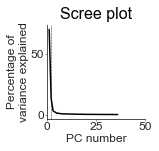

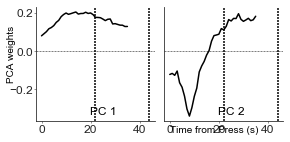

In [33]:
### PERFORM PCA FOR FUTURE CLUSTERING BASED ON THE ABOVE DATA

load_savedpca_or_dopca = 'dopca'
# Select 'dopca' for doing PCA on the data. Select 'savedpca' for loading my previous results

if load_savedpca_or_dopca == 'dopca':
    pca = PCA(n_components=populationdata.shape[1], whiten=True)
    pca.fit(populationdata) 
    with open(os.path.join(basedir, 'PNAC_HeroinRein_pcaresults.pickle'), 'wb') as f:
        pickle.dump(pca, f)
elif load_savedpca_or_dopca == 'savedpca':
    with open(os.path.join(basedir, 'PNAC_HeroinRein_pcaresults.pickle'), 'rb') as f:
        pca = pickle.load(f)
    
transformed_data = pca.transform(populationdata)
np.save(os.path.join(basedir, 'PNAC_HeroinRein_transformed_data.npy'), transformed_data)
# transformed_data = np.load(os.path.join(latebasedir, 'PNAC_SucroseSA_transformed_data.npy'))

pca_vectors = pca.components_
print ('Number of PCs = %d'%(pca_vectors.shape[0]))

x = 100*pca.explained_variance_ratio_
print(x)
xprime = x - (x[0] + (x[-1]-x[0])/(x.size-1)*np.arange(x.size))
num_retained_pcs = np.argmin(xprime)
# Number of PCs to be kept is defined as the number at which the 
# scree plot bends. This is done by simply bending the scree plot
# around the line joining (1, variance explained by first PC) and
# (num of PCs, variance explained by the last PC) and finding the 
# number of components just below the minimum of this rotated plot
print ('Number of PCs to keep = %d'%(num_retained_pcs))

fig, ax = plt.subplots(figsize=(2,2))
ax.plot(np.arange(pca.explained_variance_ratio_.shape[0]).astype(int)+1, x, 'k')
ax.set_ylabel('Percentage of\nvariance explained')
ax.set_xlabel('PC number')
ax.axvline(num_retained_pcs, linestyle='--', color='k', linewidth=0.5)
ax.set_title('Scree plot')
ax.set_xlim([0,50])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.subplots_adjust(left=0.3)
fig.subplots_adjust(right=0.98)
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(top=0.9)

colors_for_key = {}
colors_for_key['Active'] = (0,0,0) 
# colors_for_key['Inactive'] = (0.5,0.5,0)

numcols = 3.0
fig, axs = plt.subplots(int(np.ceil(num_retained_pcs/numcols)), int(numcols), sharey='all',
                        figsize=(2*numcols, 2*int(np.ceil(num_retained_pcs/numcols))))
for pc in range(num_retained_pcs):
    ax = axs.flat[pc]
    for k, tempkey in enumerate(trial_types):
        ax.plot(pca_vectors[pc, k*window_size:(k+1)*window_size], color=colors_for_key[tempkey],
                label='PC %d: %s'%(pc+1, tempkey))
    ax.axvline(int(framerate*3), linestyle='--', color='k', linewidth=1.5)
    ax.axvline(int(framerate*3)*2, linestyle='--', color='k', linewidth=1.5)
    ax.axhline(0, linestyle='--', color='k', linewidth=0.5)
    ax.annotate(s='PC %d'%(pc+1), xy=(0.45, 0.06), xytext=(0.45, 0.06), xycoords='axes fraction',
                textcoords='axes fraction', multialignment='center', size='large')
#     if pc >= num_retained_pcs-numcols:
#         ax.set_xticks([0, pre_window_size,
#                        infusionframe, window_size])
#         ax.set_xticklabels([str(int((a-pre_window_size+0.0)/framerate))
#                              for a in [0, pre_window_size,
#                                        infusionframe, window_size]])
#     else:
#         ax.set_xticks([])
#         ax.xaxis.set_ticks_position('none')
    if pc%numcols:
        ax.yaxis.set_ticks_position('none')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


fig.text(0.5, 0.05, 'Time from Press (s)', horizontalalignment='center', rotation='horizontal')
fig.text(0.02, 0.6, 'PCA weights', verticalalignment='center', rotation='vertical')
fig.tight_layout()
for ax in axs.flat[num_retained_pcs:]:
    ax.set_visible(False)

fig.subplots_adjust(wspace=0.08, hspace=0.08)
fig.subplots_adjust(bottom=0.13)


In [34]:
###CLUSTER THE DATA USING SPECTRAL CLUSTERING BASED ON THE ABOVE PCs

max_n_clusters = 8 # Maximum number of clusters expected. I already ran this with up to 20 clusters and know
# that the optimal number is 9. So, I am leaving this at 11. In your data, might be worth increasing this, but
# it will take more time to run.

possible_n_clusters = np.arange(2, max_n_clusters+1) #This requires a minimum of 2 clusters.
# When the data contain no clusters at all, it will be quite visible when inspecting the two obtained clusters, 
# as the responses of the clusters will be quite similar. This will also be visible when plotting the data in
# the reduced dimensionality PC space (done below).


possible_n_nearest_neighbors = np.array([25, 75, 150, 225, 300]) # This should be selected for each dataset
# appropriately. When 1511 neurons are present, the above number of nearest neighbors provides a good sweep of the
# parameter space. But it will need to be changed for other data.
      
silhouette_scores = np.nan*np.ones((possible_n_clusters.size,
                                    possible_n_nearest_neighbors.size))

for n_clustersidx, n_clusters in enumerate(possible_n_clusters):
    for nnidx, nn in enumerate(possible_n_nearest_neighbors):
        model = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', n_neighbors=nn)
        model.fit(transformed_data[:,:num_retained_pcs])
        silhouette_scores[n_clustersidx, nnidx] = silhouette_score(transformed_data[:,:num_retained_pcs],
                                                                   model.labels_,
                                                                   metric='cosine')
        print ('Done with numclusters = %d, num nearest neighbors = %d: score = %.3f'%(n_clusters,
                                                                                      nn,
                                                                                      silhouette_scores[n_clustersidx,                                                                           
                                                                                                        nnidx]))

print ('Done with model fitting')

temp = {}
temp['possible_n_clusters'] = possible_n_clusters
temp['possible_n_nearest_neighbors'] = possible_n_nearest_neighbors
temp['silhouette_scores'] = silhouette_scores
temp['shape'] = 'cluster_nn'
with open(os.path.join(basedir, 'PNAC_HeroinRein_silhouette_scores.pickle'), 'wb') as f:
    pickle.dump(temp, f) 
    

Done with numclusters = 2, num nearest neighbors = 25: score = 0.351
Done with numclusters = 2, num nearest neighbors = 75: score = 0.553
Done with numclusters = 2, num nearest neighbors = 150: score = 0.541
Done with numclusters = 2, num nearest neighbors = 225: score = 0.343
Done with numclusters = 2, num nearest neighbors = 300: score = 0.287
Done with numclusters = 3, num nearest neighbors = 25: score = 0.565
Done with numclusters = 3, num nearest neighbors = 75: score = 0.570
Done with numclusters = 3, num nearest neighbors = 150: score = 0.630
Done with numclusters = 3, num nearest neighbors = 225: score = 0.251
Done with numclusters = 3, num nearest neighbors = 300: score = 0.228
Done with numclusters = 4, num nearest neighbors = 25: score = 0.358
Done with numclusters = 4, num nearest neighbors = 75: score = 0.348
Done with numclusters = 4, num nearest neighbors = 150: score = 0.113
Done with numclusters = 4, num nearest neighbors = 225: score = -0.157
Done with numclusters = 4

In [35]:
###THE NEXT CELLS ALLOW YOU TO EXAMINE THE "FIT" OF EACH NEURON FOR EACH CLUSTER

with open(os.path.join(basedir, 'PNAC_HeroinRein_silhouette_scores.pickle'), 'rb') as f:
    silhouette_scores = pickle.load(f)
    
transformed_data = np.load(os.path.join(basedir, 'PNAC_HeroinRein_transformed_data.npy'))

# Identify optimal parameters from the above parameter space
temp = np.where(silhouette_scores['silhouette_scores']==np.nanmax(silhouette_scores['silhouette_scores']))
n_clusters = silhouette_scores['possible_n_clusters'][temp[0][0]]
n_nearest_neighbors = silhouette_scores['possible_n_nearest_neighbors'][temp[1][0]]

print (n_clusters, n_nearest_neighbors)

# Redo clustering with these optimal parameters
model = SpectralClustering(n_clusters=n_clusters,
                           affinity='nearest_neighbors',
                           n_neighbors=n_nearest_neighbors)

# model = KMeans(n_clusters=n_clusters, algorithm = 'elkan')

# model = AgglomerativeClustering(n_clusters=n_clusters)

model.fit(transformed_data[:,:num_retained_pcs])

temp = silhouette_score(transformed_data[:,:num_retained_pcs], model.labels_, metric='cosine')

print ('Number of clusters = %d, average silhouette = %.3f'%(len(set(model.labels_)), temp))

# Save this optimal clustering model.
with open(os.path.join(basedir, 'PNAC_HeroinRein_clusteringmodel.pickle'), 'wb') as f:
    pickle.dump(model, f)

          
# Since the clustering labels are arbitrary, I rename the clusters so that the first cluster will have the most
# positive response and the last cluster will have the most negative response.
def reorder_clusters(rawlabels):
    uniquelabels = list(set(rawlabels))
    responses = np.nan*np.ones((len(uniquelabels),))
    for l, label in enumerate(uniquelabels):
        responses[l] = np.mean(populationdata[rawlabels==label, pre_window_size:2*pre_window_size])
    temp = np.argsort(responses).astype(int)[::-1]
    temp = np.array([np.where(temp==a)[0][0] for a in uniquelabels])
    outputlabels = np.array([temp[a] for a in list(np.digitize(rawlabels, uniquelabels)-1)])
    return outputlabels
newlabels = reorder_clusters(model.labels_)

# Create a new variable containing all unique cluster labels
uniquelabels = list(set(newlabels))


colors_for_cluster = [[0.933, 0.250, 0.211],
                      [0.941, 0.352, 0.156],
                      [0.964, 0.572, 0.117],
                      [0.980, 0.686, 0.250],
                      [0.545, 0.772, 0.247],
                      [0.215, 0.701, 0.290],
                      [0, 0.576, 0.270],
                      [0, 0.650, 0.611],
                      [0.145, 0.662, 0.878]]

np.save(os.path.join(basedir, 'PNAC_HeroinRein_clusterlabels.npy'), newlabels)
###ONLY USE IF YOU WANT TO OVERWRITE EXISTING, SAVED CLUSTERING DATA

3 150
Number of clusters = 3, average silhouette = 0.624


In [36]:
def make_silhouette_plot(X, cluster_labels):
    
    n_clusters = len(set(cluster_labels))
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(4, 4)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.4, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    silhouette_avg = silhouette_score(X, cluster_labels, metric='cosine')

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels, metric='cosine')

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = colors_for_cluster[i]
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.9)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    fig.savefig(os.path.join(basedir, 'Results', 'PNAC HEROIN REIN - Cluster Silhouettes.PDF'), format='PDF')

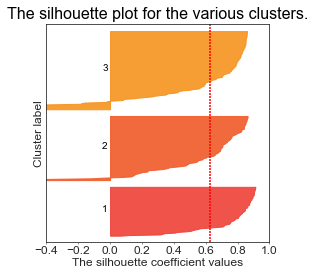

In [37]:
make_silhouette_plot(transformed_data[:,:num_retained_pcs], model.labels_)


In [26]:
####This section saves cluster IDs to each FOV Folder for future use. 
####DO NOT RUN/SAVE UNLESS YOU WANT TO OVERWRITE CLUSTER LISTS

cluster_id_list = newlabels

cellcounter = 0

##Assign cluster IDs to neurons within [early] animals of interest
for animal in early_animals_of_interest:
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(earlybasedir, animal, fov),
                                                                window_size, pre_window_size)
        numneurons = temp3.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
#         np.save(os.path.join(earlybasedir, animal, fov, fov+'cluster_list_per_fov.npy'), neuron_id_list)
firstcellearly = 0
lastcellearly = cellcounter
# np.save(os.path.join(earlybasedir, 'cluster_list_per_session_Reinstatement.npy'), newlabels[firstcellearly:lastcellearly])

##Assign cluster IDs to neurons within [early] animals of interest
for animal in middle_animals_of_interest:
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(middlebasedir, animal, fov),
                                                                window_size, pre_window_size)
        numneurons = temp3.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
#         np.save(os.path.join(middlebasedir, animal, fov, fov+'cluster_list_per_fov.npy'), neuron_id_list)
firstcellmiddle = lastcellearly
lastcellmiddle = cellcounter

# np.save(os.path.join(middlebasedir, 'cluster_list_per_session_Reinstatement.npy'), newlabels[firstcellmiddle:lastcellmiddle])
  
##Assign cluster IDs to neurons within [early] animals of interest
for animal in late_animals_of_interest:
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        temp1, temp2, temp3, temp4, framerate = analyze_single_session(os.path.join(latebasedir, animal, fov),
                                                                window_size, pre_window_size)
        numneurons = temp3.shape[2]
        neuron_id_list = []
        for neuron in np.arange(numneurons):
            neuron_id_list = np.hstack((neuron_id_list, cluster_id_list[cellcounter+neuron]))
        cellcounter = numneurons + cellcounter
#         np.save(os.path.join(latebasedir, animal, fov, fov+'cluster_list_per_fov.npy'), neuron_id_list)    

firstcelllate = lastcellmiddle
lastcelllate = cellcounter

# np.save(os.path.join(latebasedir, 'cluster_list_per_session_Reinstatement.npy'), newlabels[firstcelllate:lastcelllate])



# PLOT ENSEMBLES BELOW. NO NEED TO REDO CLUSTERING

In [29]:
###LOAD DATA AND CLUSTERING ASSIGNMENTS FOR PLOTTING

early_populationdata = early_active
middle_populationdata = middle_active
late_populationdata = late_active
all_populationdata = np.vstack((early_active, middle_active, late_active))

early_newlabels=np.load(os.path.join(earlybasedir, 'cluster_list_per_session_Reinstatement.npy'))
middle_newlabels=np.load(os.path.join(middlebasedir, 'cluster_list_per_session_Reinstatement.npy'))
late_newlabels=np.load(os.path.join(latebasedir, 'cluster_list_per_session_Reinstatement.npy'))
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

/var/folders/pk/ygvbglbn6bq1fx39y5xg76dc0000gn/T/ipykernel_10554/53195807.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


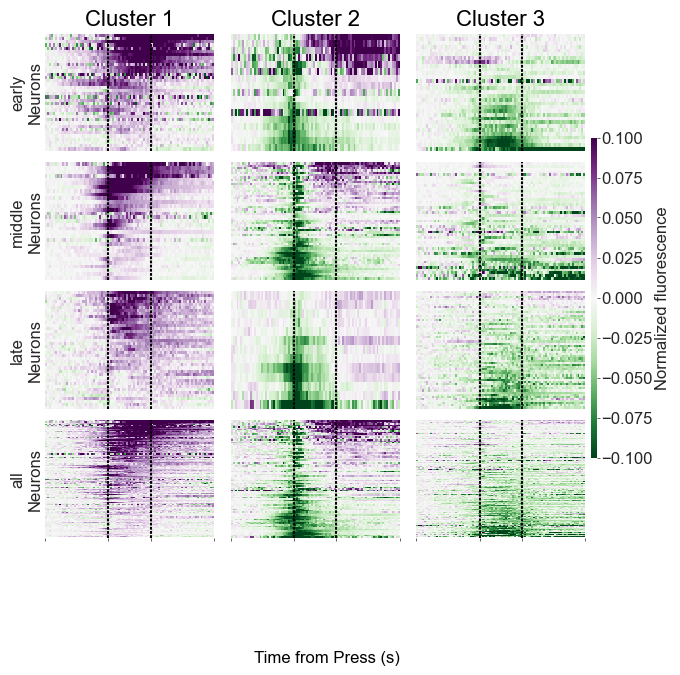

In [31]:
### PLOT CLUSTERED DATA AS HEATMAPS FOR EACH DAY

sessions = ['early', 'middle', 'late','all'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 3 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for c, cluster in enumerate(uniquelabels):
    sortwindow[c] = {}
    if c == 0:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 1:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 2:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    if c == 3:
        sortwindow[c] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numroisincluster = np.nan*np.ones((len(uniquelabels),))

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numroisincluster[c] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[c][0]:sortwindow[c][1]], axis=1))[::-1]
        sns.heatmap(temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=plt.get_cmap('PRGn_r'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence'})
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size,
                                        infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from Press (s)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


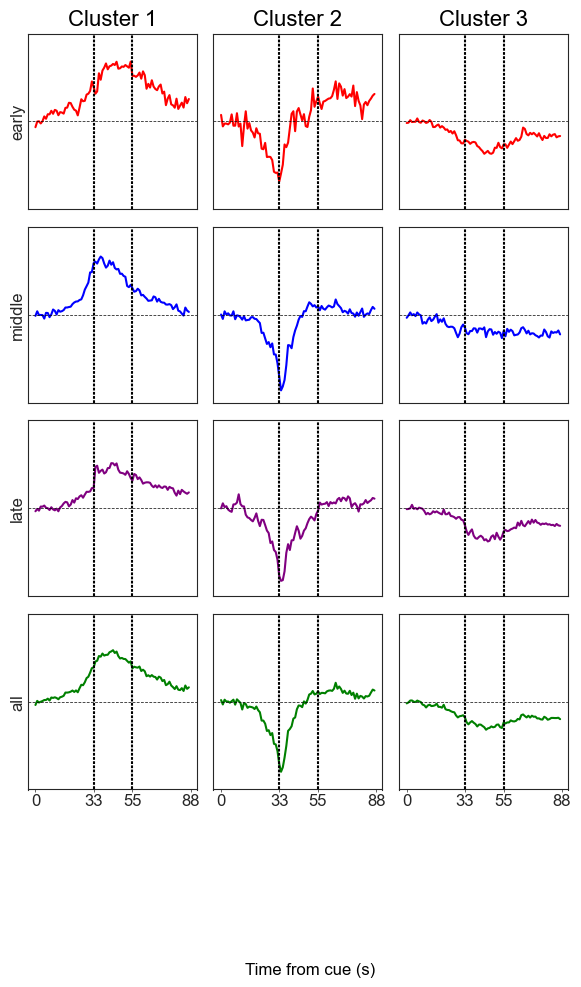

In [34]:
### PLOT CLUSTERS AS LINE PLOTS FOR EACH DAY

fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numroisincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for c, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
        numroisincluster[c] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, c])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.1, .1))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axvline(infusionframe, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


# DECODING, START HERE IF YOU WANT A NEW DECODING ANALYSIS

In [9]:
###REQUIRED PACKAGES
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
import scipy.io as sio
import os
import subprocess
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from sklearn.decomposition import PCA
from statsmodels.distributions.empirical_distribution import ECDF

In [10]:
###FUNCTIONS
def binaryclassifier(y, X):
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    clf = GridSearchCV(SVC(), hyperparameters, cv=10)
    if np.any(np.isnan(X)):
        accuracy=np.nan
        print ('nan detected in single neuron! within ', fov)
    else:
        clf.fit(X, y)
        accuracy = clf.best_score_
    return accuracy

def svmregression(y, X):
    hyperparameters = {'kernel': ['rbf'], 'C': np.logspace(-3, 3, 5),
                      'epsilon': np.logspace(-3, 3, 5),
                      'gamma': np.logspace(-5, 5, 10)}
    clf = GridSearchCV(SVR(), hyperparameters, cv=10)
    if np.all(np.isnan(X)):
        R2=np.nan
    else:
        clf.fit(X, y)
        """y_pred = clf.predict(X)
        plt.plot(y,y_pred,'ko')"""
        R2 = clf.best_score_
    #reference for 10-fold cross-validation http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf
    return R2

# DECODING - NO NEED TO RUN IF YOU'VE ALREADY SAVED DECODING RESULTS

In [35]:
###DECODING. Note: this takes time (e.g., ~45 minutes for 3500 neurons). Be sure your parameters below (~line 73) are what you want

groups = ['CueRein'] ###INSERT YOUR GROUPS (E.G., EARLY AND LATE LEARNING)
session_analysis_split_by_ensemble = ['No'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['Neuron', 'Trial'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 3 ###SET TO NUMBER OF CLUSTERS

baseline = [0, 7]  ###These variables are for assigning neuronal data epochs
leverresponse = [pre_window_size-4, pre_window_size+4]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numroisincluster = np.nan*np.ones((numclusters,))

datadir=0
for group in groups:
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}
    classification_accuracy[group]['session'] = {}
    classification_accuracy[group]['session']['shuffled'] = {}
    classification_accuracy[group]['session']['unshuffled'] = {}
    
    if group == 'YOHRein':
        animals_of_interest = early_animals_of_interest   
    if group == 'DrugRein':
        animals_of_interest = middle_animals_of_interest  
    if group == 'CueRein':
        animals_of_interest = late_animals_of_interest
        if session_analysis_split_by_ensemble == ['Yes']:
            for c, cluster in enumerate(uniquelabels):
                classification_accuracy[group]['session']['shuffled'][c] = {}
                classification_accuracy[group]['session']['unshuffled'][c] = {}

    numneuronstillnow = 0
    for animal in animals_of_interest:
        fovs = next(os.walk(os.path.join(basedir, group, animal)))[1]
        for fov in sorted(fovs):
            print(group, animal, fov)
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'LateAcq':
                cluster_id_list_fov = np.load(os.path.join(basedir, group, animal, fov, fov+'cluster_list_per_fov.npy'))
            temp1, temp2, activetrials, temp4, framerate = analyze_single_session(os.path.join(basedir, group, animal, fov),
                                                            window_size, pre_window_size)
            
            ###THIS SECTION DELETES ANY TRIALS WITH NANs
            for i in reversed(range(activetrials.shape[0])): ###reversed to prevent deletion from messing up indexing
                if np.isnan(np.mean(activetrials[i,:,:])):
                    activetrials = np.delete(activetrials, i, axis = 0)

            ###THIS SECTION ALIGNS DATA FOR DECODING        
            numtrials = activetrials.shape[0]
            numsamples = activetrials.shape[1]
            numneuronsinfov = activetrials.shape[2]

            baseline_active = np.nan*np.ones((numtrials,numneuronsinfov))
            response_active = np.nan*np.ones((numtrials,numneuronsinfov))

            activeflag = np.hstack((np.zeros((numtrials)), np.ones((numtrials))))
            
            for neuron in range(numneuronsinfov):
                print(numneuronsinfov)
                baseline_active[:,neuron] = np.nanmean(activetrials[:,baseline[0]:baseline[1],neuron], axis=1)
                response_active[:,neuron] = np.nanmean(activetrials[:,leverresponse[0]:leverresponse[1],neuron], axis=1)
                
                ###CHANGE THESE VARIABLES TO ADJUST WHAT YOU ARE DECODING AND ENSURE IT ALIGNS WITH YOUR FLAGS
                neuralactivity_trialtype = np.vstack((baseline_active, response_active)) ###FOR COMPARING TRIAL TYPES
                
               ###TRIAL DECODING IN SINGLE NEURONS
                if session_analysis_split_by_ensemble == ['No'] and decoding == ['Neuron','Trial']:
                    classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = \
                        binaryclassifier(activeflag, np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))

                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag,\
                                np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1))
                    classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = \
                        shuffledresults
            
            ###TRIAL DECODING BY SESSION
            if session_analysis_split_by_ensemble == ['No'] and decoding == ['Session','Trial']:
                    classification_accuracy[group]['session']['unshuffled'][fov] = \
                        binaryclassifier(activeflag,neuralactivity_trialtype)                                                                           
                    shuffledresults = np.nan*np.ones((numshuffles,))
                    for shuffleid in range(numshuffles):
                        shuffled_flag = np.random.permutation(activeflag)
                        shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, neuralactivity_trialtype)
                    classification_accuracy[group]['session']['shuffled'][fov] = shuffledresults

            
            ###TRIAL DECODING BY SESSION & ENSEMBLE
            if session_analysis_split_by_ensemble == ['Yes'] and group == 'LateAcq' and decoding == ['Session', 'Trial']:
                for c, cluster in enumerate(uniquelabels):
                    if np.count_nonzero(cluster_id_list_fov==c) > 1:
                        temp = np.squeeze(neuralactivity_trialtype[:, np.where(cluster_id_list_fov==cluster)])
                        classification_accuracy[group]['session']['unshuffled'][c][fov] = \
                            binaryclassifier(activeflag,temp)                                                             
                        shuffledresults = np.nan*np.ones((numshuffles,))
                        for shuffleid in range(numshuffles):
                            shuffled_flag = np.random.permutation(activeflag)
                            shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, temp)
                        classification_accuracy[group]['session']['shuffled'][c][fov] = shuffledresults

            numneuronstillnow += numneurons


In [1]:
###THIS SECTION IS TO SAVE DECODING DATA AS NUMPY ARRAYS
save_results = 'Yes'
variable_to_save = 'ActivePress'

if save_results == 'Yes':
    ### THIS SECTION IS FOR SAVING NEW DECODING RESULTS FOR SINGLE NEURON ANALYSES NOT YET SPLIT BY ENSEMBLE
    if session_analysis_split_by_ensemble == ['No'] and decoding[0]=='Neuron':
        for g, group in enumerate (groups):
            unshuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['unshuffled'])))[:,1]
            shuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['shuffled'])))[:,1]
            stacked = np.vstack((unshuffled, shuffled))
            np.save(os.path.join(basedir,'Results','Decoding',\
                     'PNAC_HeroinRein_%s_%s_Decoding_Population_%s.npy'%(group,variable_to_save,decoding[0])),stacked)
    else:
        print ('Data Not Saved')